# Network of networks

Networks where created, this networks have topologies and functions. The topological and dynamic distance was compared.

Each network has a name that corresponds to: 
* MOTIF: motif of network
* ID, ID: parameter of order
* MODEL: Number of model/function

Only comparisons between different networks where taken into account.

In [1]:
# Import
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline  

Load data

In [2]:
# Load data
data = np.genfromtxt('distances.csv', delimiter=',')
# remove header
data = np.delete(data, 0, 0)
#data

Distribution of topological distances

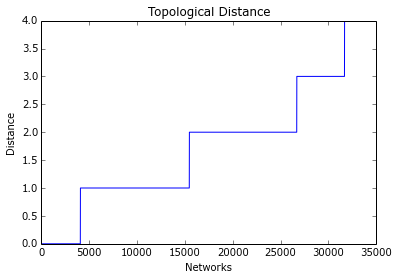

In [3]:
d_top = sorted(data[:,2])
plt.plot(d_top, 'b')
plt.xlabel('Networks')
plt.ylabel('Distance')
plt.title('Topological Distance')
plt.show()

Networks that have d_top = 0:

Is distance correct? 

The network 1001 is:

    Topology: 
    GENE1->GENE2
    GENE2->GENE3
    INP1->GENE1
    Total number of satisfying models found: 1

The network 2001 is:

    Topology: 
    GENE1->GENE2
    GENE2-|GENE3
    INP1->GENE1
    Total number of satisfying models found: 1

In [7]:
for d in data:
    if d[2] == 0: print(d)

[ 1001.  2001.     0.     4.]
[ 1001.  3001.     0.     4.]
[ 1001.          4001.             0.             5.65685425]
[ 1011.          1021.             0.             2.82842712]
[ 1011.  2011.     0.     4.]
[ 1011.          2021.             0.             4.89897949]
[ 1011.  3011.     0.     4.]
[ 1011.          3021.             0.             4.89897949]
[ 1011.          4011.             0.             5.65685425]
[ 1011.          4021.             0.             6.32455532]
[ 1021.          2011.             0.             4.89897949]
[ 1021.  2021.     0.     4.]
[ 1021.          3011.             0.             4.89897949]
[ 1021.  3021.     0.     4.]
[ 1021.          4011.             0.             6.32455532]
[ 1021.          4021.             0.             5.65685425]
[ 1031.  2061.     0.     4.]
[ 1031.          3061.             0.             4.89897949]
[ 1031.          4031.             0.             4.89897949]
[ 1041.          1051.             0.         

Distribution of dynamic distances

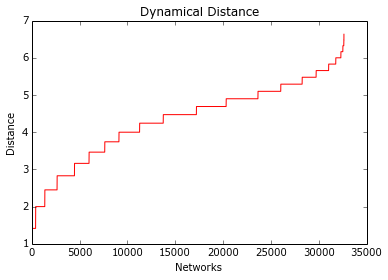

In [4]:
d_dyn = sorted(data[:,3])
plt.plot(d_dyn, 'r')
plt.xlabel('Networks')
plt.ylabel('Distance')
plt.title('Dynamical Distance')
plt.show()

* Does it follows a distribution?

Topological vs dynamic distances

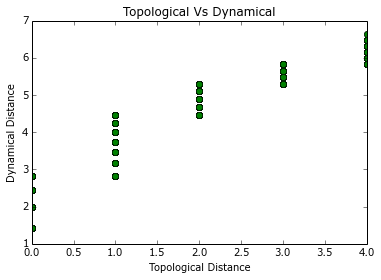

In [5]:
plt.plot(d_top, d_dyn, 'go')
plt.xlabel('Topological Distance')
plt.ylabel('Dynamical Distance')
plt.title('Topological Vs Dynamical')
plt.show()

This is confusing, maybe add a third axis and sort in a better way...